<a href="https://colab.research.google.com/github/Jango9850/PA2/blob/main/PA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/dataset.zip # Vor dem Ausführen auf den fertigen Upload der .zip datei warten

Archive:  /content/dataset.zip
   creating: dataset/
 extracting: dataset/data.yaml       
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/img_0301.jpg  
   creating: dataset/test/labels/
   creating: dataset/train/
   creating: dataset/train/images/
  inflating: dataset/train/images/img_0289.jpg  
  inflating: dataset/train/images/img_0290.jpg  
  inflating: dataset/train/images/img_0291.jpg  
  inflating: dataset/train/images/img_0292.jpg  
  inflating: dataset/train/images/img_0294.jpg  
  inflating: dataset/train/images/img_0297.jpg  
  inflating: dataset/train/images/img_0298.jpg  
  inflating: dataset/train/images/img_0302.jpg  
  inflating: dataset/train/images/img_0303.jpg  
   creating: dataset/train/labels/
   creating: dataset/val/
   creating: dataset/val/images/
  inflating: dataset/val/images/img_0299.jpg  
  inflating: dataset/val/images/img_0300.jpg  
   creating: dataset/val/labels/


In [ ]:
# Install albumentations
!pip install albumentations opencv-python tqdm --quiet

In [ ]:
# Importiere notwendige Bibliotheken
import json
import os
import cv2
import numpy as np
from albumentations import (
    Rotate, RandomBrightnessContrast, GaussNoise, Blur, Compose,
    GaussianBlur, MotionBlur, ISONoise
)
from tqdm import tqdm

# Definiere den Basis-Pfad zum Datensatz
base_dataset_dir = '/content/dataset'

# Pfad zur VIA JSON-Annotationsdatei
annotation_file = '/content/PA2_Annotation_json.json'

# Subverzeichnisse für train, val und test
subsets = ['train', 'val', 'test']

# Definiere Klassen-Mappings basierend auf den region_attributes
class_name_to_id = {'Plank': 0}
num_classes = len(class_name_to_id)

# Definiere Augmentierungen gemäß dem zweiten Skript
augmentations = {
    'rotation_plus_90': Rotate(limit=(90, 90), p=1, border_mode=cv2.BORDER_CONSTANT),
    'rotation_minus_90': Rotate(limit=(-90, -90), p=1, border_mode=cv2.BORDER_CONSTANT),
    'noise': GaussNoise(var_limit=(100.0, 1000.0), mean=0, p=1),
    'iso_noise': ISONoise(color_shift=(0.05, 0.1), intensity=(0.5, 1.0), p=1),
    'brightness': RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.0, p=1),
    'blur': Blur(blur_limit=(11, 41), p=1),
    'contrast': RandomBrightnessContrast(brightness_limit=0.0, contrast_limit=0.5, p=1)
}

# Lade die VIA-Annotationen
with open(annotation_file, 'r') as f:
    via_data = json.load(f)

# Baue eine Zuordnung von Subsets zu Dateinamen und deren Annotationen
image_data = {subset: {} for subset in subsets}

for key, value in via_data.items():
    filename = value['filename']
    regions = value.get('regions', [])

    # Bestimmen, zu welchem Subset das Bild gehört
    # Hier nehmen wir an, dass die Bilder bereits in den entsprechenden Unterverzeichnissen liegen
    subset_assigned = False
    for subset in subsets:
        image_path = os.path.join(base_dataset_dir, subset, 'images', filename)
        if os.path.exists(image_path):
            image_data[subset][filename] = {
                'regions': regions,
                'file_attributes': value.get('file_attributes', {})
            }
            subset_assigned = True
            break
    if not subset_assigned:
        print(f"Warnung: Bild {filename} konnte keinem Subset zugeordnet werden. Überspringe...")

# Loop über jedes Subset (train, val, test)
for subset in subsets:
    print(f"\nVerarbeite das {subset}-Set...")
    image_dir = os.path.join(base_dataset_dir, subset, 'images')
    label_dir = os.path.join(base_dataset_dir, subset, 'labels')

    # Überprüfen, ob die Verzeichnisse existieren
    if not os.path.exists(image_dir):
        print(f"Image-Verzeichnis {image_dir} existiert nicht.")
        continue
    if not os.path.exists(label_dir):
        print(f"Label-Verzeichnis {label_dir} existiert nicht. Erstelle es...")
        os.makedirs(label_dir)

    # Verzeichnisse zum Speichern augmentierter Bilder und Annotationen (nur für train)
    augmented_image_dir = image_dir  # Augmentierte Bilder werden im selben Ordner gespeichert
    augmented_label_dir = label_dir  # Augmentierte Annotationen werden im selben Ordner gespeichert

    # Liste der Original-Bilddateien (exklusive augmentierter Bilder)
    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png')) and f in image_data.get(subset, {})]

    # Loop über jedes Bild und verarbeite es
    for filename in tqdm(image_files, desc=f"Verarbeite {subset}-Bilder"):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Bild {filename} nicht gefunden.")
            continue

        height, width = image.shape[:2]

        # Holen der Annotationen für das Bild
        regions = image_data[subset][filename]['regions']
        bboxes = []
        category_ids = []

        for region in regions:
            shape_attributes = region['shape_attributes']
            region_attributes = region.get('region_attributes', {})
            class_id = None

            # Bestimmen der Klasse basierend auf region_attributes
            # Da nur eine Klasse "Plank" existiert, setzen wir diese direkt
            class_id = class_name_to_id.get('Plank', 0)

            if class_id is None:
                # Keine gültige Klasse gefunden, überspringen
                print(f"Warnung: Keine gültige Klasse für eine Region in {filename}. Überspringe diese Region.")
                continue

            if shape_attributes['name'] == 'rect':
                x = shape_attributes['x']
                y = shape_attributes['y']
                w = shape_attributes['width']
                h = shape_attributes['height']
                x_min = x
                y_min = y
                x_max = x + w
                y_max = y + h
            elif shape_attributes['name'] == 'polygon':
                all_points_x = shape_attributes['all_points_x']
                all_points_y = shape_attributes['all_points_y']
                x_min = min(all_points_x)
                y_min = min(all_points_y)
                x_max = max(all_points_x)
                y_max = max(all_points_y)
            else:
                continue

            # Begrenze die Bounding Boxes auf die Bildabmessungen
            x_min = max(0, min(x_min, width - 1))
            x_max = max(0, min(x_max, width - 1))
            y_min = max(0, min(y_min, height - 1))
            y_max = max(0, min(y_max, height - 1))

            bboxes.append([x_min, y_min, x_max, y_max])
            category_ids.append(class_id)

        if not bboxes:
            print(f"Warnung: Keine gültigen Bounding Boxes für {filename}. Erstelle eine leere Label-Datei.")

        # Konvertiere Bounding Boxes ins Albumentations-Format (x_min, y_min, x_max, y_max)
        albumentations_bboxes = []
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            albumentations_bboxes.append([x_min, y_min, x_max, y_max])

        # Speichere die Original-Annotationen im YOLO-Format
        original_base_name, ext = os.path.splitext(filename)
        original_annotation_path = os.path.join(augmented_label_dir, original_base_name + '.txt')

        yolo_annotations = []
        for bbox, category_id in zip(albumentations_bboxes, category_ids):
            x_min, y_min, x_max, y_max = bbox
            x_center = ((x_min + x_max) / 2) / width
            y_center = ((y_min + y_max) / 2) / height
            width_norm = (x_max - x_min) / width
            height_norm = (y_max - y_min) / height
            yolo_annotations.append(f"{category_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}")

        # Speichere Original-Annotationen für alle Subsets
        with open(original_annotation_path, 'w') as f:
            for annotation in yolo_annotations:
                f.write(f"{annotation}\n")

        # Wende nur Augmentierungen auf das Trainingsset an
        if subset == 'train':                               # Änderun um train, test, val in die Augmentierung aufzunehmen/ auszuschließen
            for aug_name, aug in augmentations.items():
                # Definiere die Transformations-Pipeline
                transform = Compose(
                    [aug],
                    bbox_params={
                        'format': 'pascal_voc',
                        'min_area': 0,
                        'min_visibility': 0,
                        'label_fields': ['category_ids']
                    }
                )

                # Wende die Augmentierung an
                transformed = transform(image=image, bboxes=albumentations_bboxes, category_ids=category_ids)
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                transformed_category_ids = transformed['category_ids']

                # Überspringe, wenn keine Bounding Boxes nach der Augmentierung vorhanden sind
                if not transformed_bboxes:
                    print(f"Info: Keine Bounding Boxes nach der Augmentierung '{aug_name}' für {filename}. Überspringe...")
                    continue

                # Speichere das augmentierte Bild
                base_name, ext = os.path.splitext(filename)
                aug_file_name = f"{base_name}_{aug_name}{ext}"
                aug_image_path = os.path.join(augmented_image_dir, aug_file_name)
                cv2.imwrite(aug_image_path, transformed_image)

                # Speichere die Annotationen im YOLO-Format
                yolo_annotations_aug = []
                for bbox, category_id in zip(transformed_bboxes, transformed_category_ids):
                    x_min, y_min, x_max, y_max = bbox
                    x_center = ((x_min + x_max) / 2) / transformed_image.shape[1]
                    y_center = ((y_min + y_max) / 2) / transformed_image.shape[0]
                    width_norm = (x_max - x_min) / transformed_image.shape[1]
                    height_norm = (y_max - y_min) / transformed_image.shape[0]
                    yolo_annotations_aug.append(f"{category_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}")

                # Speichere Annotationen nur für das Trainingsset
                annotation_filename = f"{base_name}_{aug_name}.txt"
                annotation_path = os.path.join(augmented_label_dir, annotation_filename)
                with open(annotation_path, 'w') as f:
                    for annotation in yolo_annotations_aug:
                        f.write(f"{annotation}\n")

    print(f"Beendet die Verarbeitung des {subset}-Sets.")

# Erstelle die data.yaml Datei
data_yaml_content = f"""path: {base_dataset_dir}
train: train/images
val: val/images
test: test/images  # optional
nc: {num_classes}
names: {list(class_name_to_id.keys())}
"""

data_yaml_path = os.path.join(base_dataset_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

print("\nDataset-Vorbereitung abgeschlossen. Die data.yaml Datei wurde erstellt unter:", data_yaml_path)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Warnung: Bild 20240925_5_central.jpg konnte keinem Subset zugeordnet werden. Überspringe...
Warnung: Bild 20240925_25_8_central.jpg konnte keinem Subset zugeordnet werden. Überspringe...

Verarbeite das train-Set...


Verarbeite train-Bilder:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Verarbeite train-Bilder: 100%|██████████| 9/9 [01:05<00:00,  7.29s/it]


Beendet die Verarbeitung des train-Sets.

Verarbeite das val-Set...


Verarbeite val-Bilder: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Beendet die Verarbeitung des val-Sets.

Verarbeite das test-Set...


Verarbeite test-Bilder: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

Beendet die Verarbeitung des test-Sets.

Dataset-Vorbereitung abgeschlossen. Die data.yaml Datei wurde erstellt unter: /content/dataset/data.yaml


In [ ]:
# Install Ultralytics
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define paths
dataset_path = '/content/dataset'
data_yaml_path = os.path.join(dataset_path, 'data.yaml')

# Load a pretrained YOLOv model
model = YOLO('yolo11n.pt') # Yolo Version angeben (yolov8n, yolo11n)

# Fine-tune the model on your dataset
results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=1024,
    batch=3,
    conf= 0.4,
    name='custom_yolo11n',
    verbose=True,
    amp=True,   #  Aktiviere gemischte Präzision (16 & 32 Bit Berechnung für gradienten) für schnelleres Training
    cache=True
    #freeze = 10, um die ersten 10 schichten des yolov modells (Backbone) nicht mitzutrainieren (transfer learning)
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 223MB/s] 


Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/dataset/data.yaml, epochs=50, time=None, patience=100, batch=3, imgsz=1024, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=custom_yolo11n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 19.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.4MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<00:00, 1235.64it/s]

train: New cache created: /content/dataset/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 72/72 [00:20<00:00,  3.54it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/val/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 407.75it/s]

val: New cache created: /content/dataset/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Plotting labels to runs/detect/custom_yolo11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0004921875), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/custom_yolo11n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.52G      1.537      3.033      1.638         30       1024: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          2          8      0.102      0.375     0.0779     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.47G      1.506       3.64      1.606         18       1024: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]

                   all          2          8      0.102      0.375     0.0779     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.46G      1.871      3.764      1.977          7       1024: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all          2          8      0.102      0.375     0.0779     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.46G      1.873      3.215      1.985         24       1024: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

                   all          2          8    0.00236      0.125    0.00247   0.000247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.46G       2.08      3.307      2.164         18       1024: 100%|██████████| 24/24 [00:08<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]

                   all          2          8    0.00236      0.125    0.00247   0.000247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.46G      1.757      3.103      1.932         15       1024: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]

                   all          2          8     0.0155      0.375     0.0119    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.46G      1.619      2.621      1.785         15       1024: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all          2          8     0.0155      0.375     0.0119    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.46G      1.486       2.45      1.725         29       1024: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]

                   all          2          8     0.0155      0.375     0.0119    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.46G      1.448      2.236      1.703         21       1024: 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]

                   all          2          8     0.0312      0.125      0.126     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.46G      1.243      2.079      1.552          9       1024: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

                   all          2          8    0.00167      0.125   0.000945   9.45e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.46G      1.121      1.972      1.466         41       1024: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]

                   all          2          8     0.0224      0.125     0.0126    0.00274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.45G      1.133      1.882      1.487         34       1024: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

                   all          2          8    0.00333       0.25    0.00247   0.000664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.46G      1.027      1.862      1.391         17       1024: 100%|██████████| 24/24 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

                   all          2          8      0.225      0.125     0.0727     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.46G     0.9459      1.871      1.338         23       1024: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

                   all          2          8     0.0443      0.125     0.0124    0.00176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.46G     0.9072      1.637      1.338         26       1024: 100%|██████████| 24/24 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

                   all          2          8     0.0443      0.125     0.0124    0.00176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.45G     0.8723      1.642      1.292         28       1024: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]

                   all          2          8      0.159      0.375     0.0979     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.46G     0.8337      1.406      1.225         36       1024: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]

                   all          2          8       0.52       0.75      0.594      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.46G     0.8707      1.302      1.225         14       1024: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

                   all          2          8      0.633       0.75      0.592      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.46G     0.7995      1.425      1.242         25       1024: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

                   all          2          8      0.602      0.625      0.698      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.46G     0.8147      1.277      1.198         26       1024: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]

                   all          2          8       0.66       0.75      0.722      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.46G     0.7662      1.285      1.201         12       1024: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

                   all          2          8      0.645       0.25      0.364      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.46G     0.7225      1.162      1.175         31       1024: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all          2          8      0.548      0.608      0.498      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.46G     0.7936      1.223      1.265         34       1024: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]

                   all          2          8      0.557       0.75      0.594      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.44G     0.6553      1.039      1.106         32       1024: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

                   all          2          8      0.526       0.75      0.634      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.46G     0.6245      1.017      1.074         26       1024: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

                   all          2          8      0.812        0.5      0.686      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.46G     0.6588      1.065      1.129         16       1024: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

                   all          2          8      0.944        0.5      0.724      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.45G     0.6668      1.084      1.132         21       1024: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]

                   all          2          8      0.614      0.875      0.715       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.46G     0.5969     0.9246      1.074         16       1024: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]

                   all          2          8      0.748      0.744      0.746      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.46G     0.6191     0.9452       1.08         13       1024: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]

                   all          2          8      0.529      0.875      0.726      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.45G     0.5751     0.9255      1.048         15       1024: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

                   all          2          8      0.944      0.625      0.764      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.46G     0.5895     0.9038      1.057         51       1024: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]

                   all          2          8      0.928       0.75      0.807      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.47G      0.647      1.025      1.153         20       1024: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]

                   all          2          8      0.606      0.625      0.638      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.45G      0.564     0.8432      1.052         14       1024: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]

                   all          2          8      0.963        0.5      0.693      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.46G     0.5799      0.878      1.078         17       1024: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]

                   all          2          8      0.645       0.75      0.723      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.46G     0.5926     0.8891      1.072         16       1024: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]

                   all          2          8      0.745      0.734      0.706       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.46G     0.5145     0.8346      1.053         15       1024: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]

                   all          2          8      0.776      0.868      0.737      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.47G     0.5234     0.7873      1.033         32       1024: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]

                   all          2          8      0.684      0.875      0.712      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.45G     0.5057     0.8357      1.013         11       1024: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

                   all          2          8      0.737       0.75      0.697      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.46G     0.4921      0.769      1.015          9       1024: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

                   all          2          8      0.749      0.745      0.698      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.46G      0.467     0.7187     0.9975         19       1024: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]

                   all          2          8      0.641       0.75      0.734      0.587


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.46G       0.93      1.382      1.453          4       1024: 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

                   all          2          8      0.645       0.75      0.731      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.46G     0.9897      1.196      1.559          5       1024: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]

                   all          2          8       0.74      0.715      0.721      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.47G      1.027       1.25        1.6         14       1024: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]

                   all          2          8      0.668      0.625      0.718       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.46G     0.9749      1.196      1.512          7       1024: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

                   all          2          8      0.679      0.798      0.698      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.46G      1.015      1.145       1.59          5       1024: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

                   all          2          8      0.681      0.875      0.726      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.46G     0.9429      1.089      1.503          6       1024: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]

                   all          2          8      0.576      0.875      0.726      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.46G     0.9899      1.096       1.57          6       1024: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]

                   all          2          8       0.58      0.875      0.738      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.45G     0.8917      1.053      1.486         16       1024: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

                   all          2          8      0.581      0.875      0.738      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.46G     0.7967     0.9556      1.383          4       1024: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]

                   all          2          8      0.579      0.875      0.754      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.46G     0.8182      0.967      1.365          6       1024: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

                   all          2          8      0.824      0.625      0.786      0.603



50 epochs completed in 0.124 hours.
Optimizer stripped from runs/detect/custom_yolo11n/weights/last.pt, 40.6MB
Optimizer stripped from runs/detect/custom_yolo11n/weights/best.pt, 40.6MB

Validating runs/detect/custom_yolo11n/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


                   all          2          8      0.929       0.75      0.807      0.665
Speed: 0.5ms preprocess, 27.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/custom_yolo11n


Predictions on Train Images:


Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]


image 1/1 /content/dataset/train/images/img_0290.jpg: 1024x768 (no detections), 205.6ms
Speed: 42.8ms preprocess, 205.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 768)


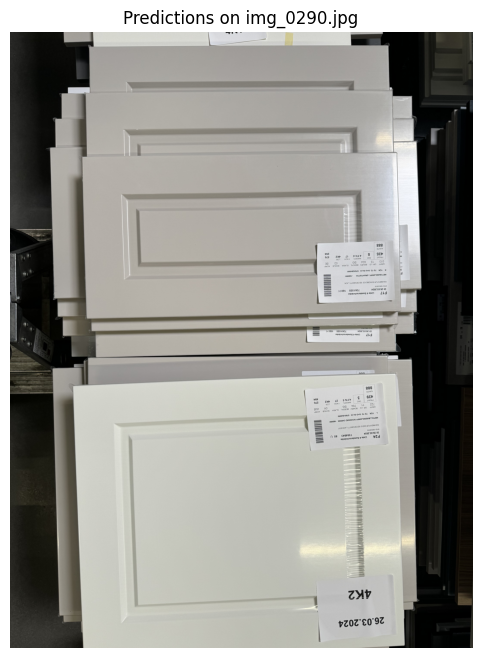

Processing Images:  20%|██        | 1/5 [00:09<00:36,  9.06s/it]


image 1/1 /content/dataset/train/images/img_0298.jpg: 768x1024 (no detections), 91.7ms
Speed: 9.5ms preprocess, 91.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


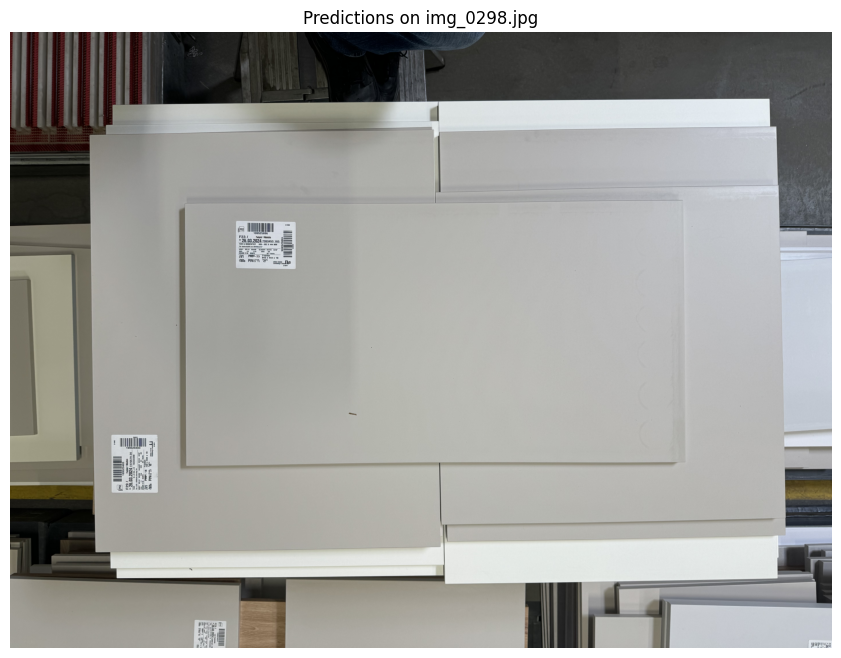

Processing Images:  40%|████      | 2/5 [00:16<00:24,  8.14s/it]


image 1/1 /content/dataset/train/images/img_0303.jpg: 1024x768 11 Planks, 82.3ms
Speed: 28.2ms preprocess, 82.3ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 768)


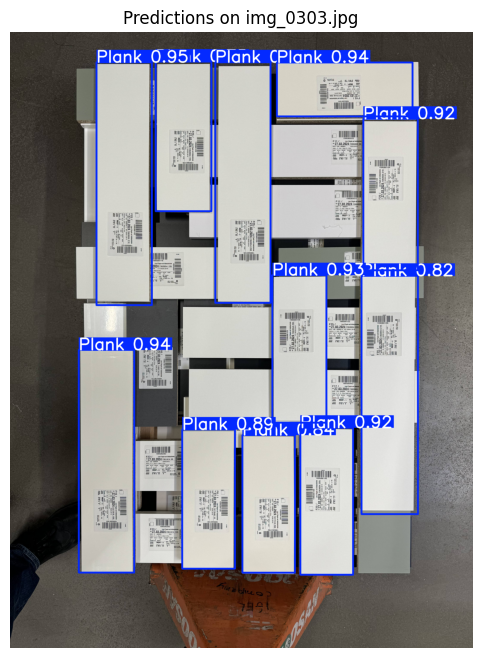

Processing Images:  60%|██████    | 3/5 [00:22<00:14,  7.25s/it]


image 1/1 /content/dataset/train/images/img_0291.jpg: 768x1024 (no detections), 66.7ms
Speed: 6.7ms preprocess, 66.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


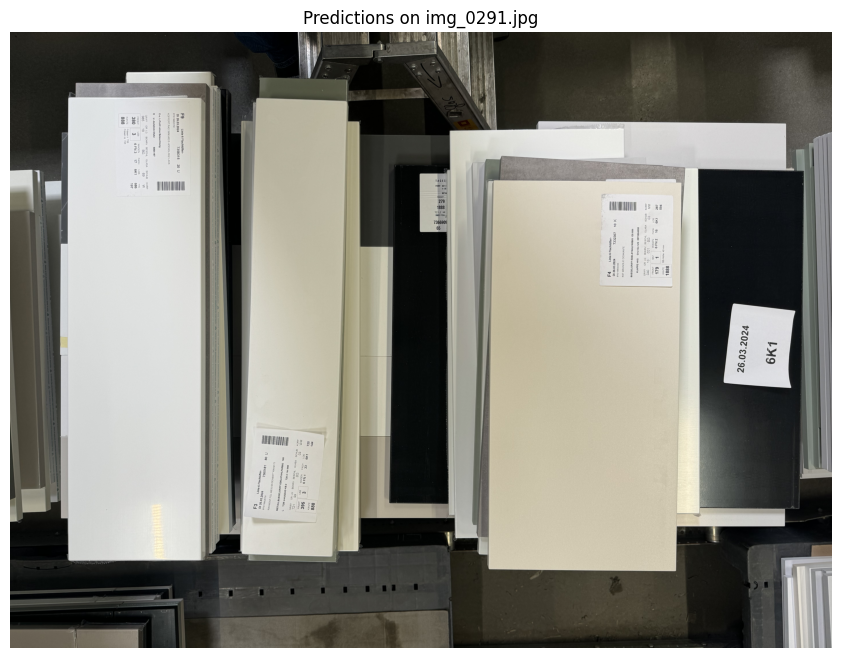

Processing Images:  80%|████████  | 4/5 [00:25<00:05,  5.64s/it]


image 1/1 /content/dataset/train/images/img_0294.jpg: 1024x768 (no detections), 66.7ms
Speed: 6.8ms preprocess, 66.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 768)


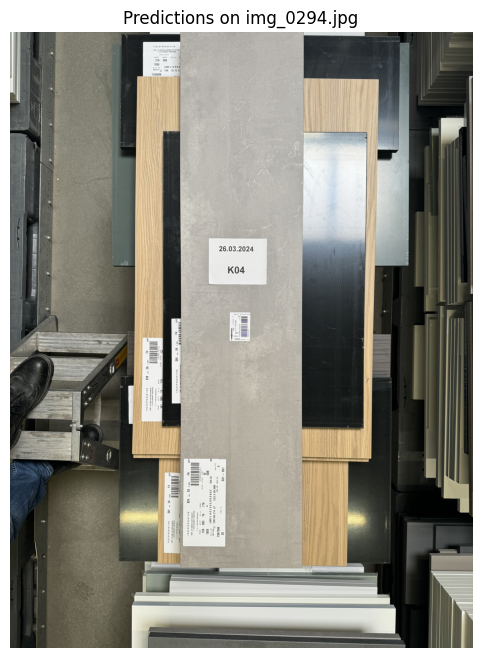

Processing Images: 100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


Predictions on Test Images:


Processing Images:   0%|          | 0/1 [00:00<?, ?it/s]


image 1/1 /content/dataset/test/images/img_0301.jpg: 768x1024 (no detections), 66.6ms
Speed: 6.6ms preprocess, 66.6ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


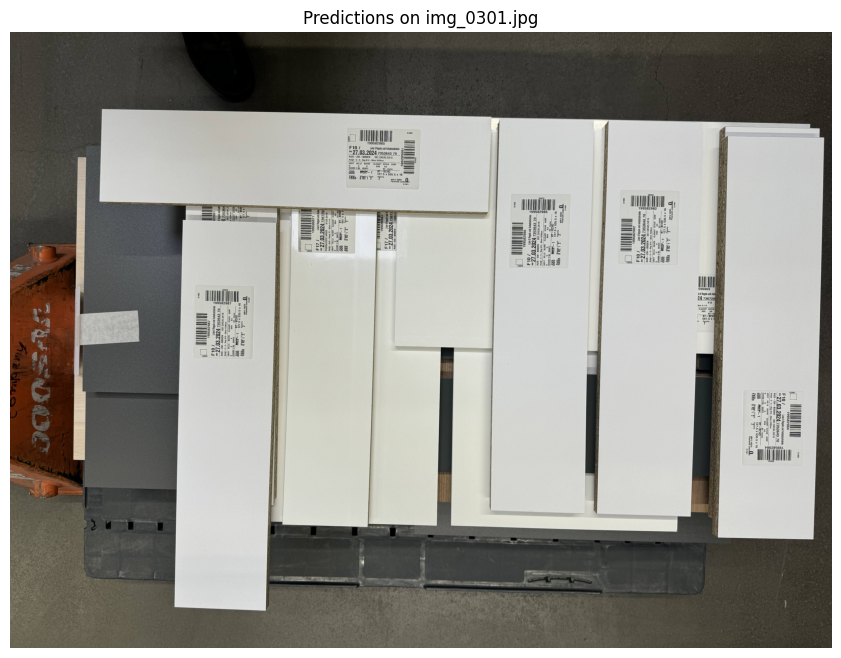

Processing Images: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


In [ ]:
# Load the best trained model
best_model_path = '/content/runs/detect/custom_yolo11n/weights/best.pt'
model = YOLO(best_model_path)

# Function to get original images
def get_original_images(image_dir):
    image_files = [f for f in os.listdir(image_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png')) and f.count('_') <= 1]
    return image_files


# Directories for train and test images
train_image_dir = os.path.join(dataset_path, 'train', 'images')
test_image_dir = os.path.join(dataset_path, 'test', 'images')

# Get original images
train_images = get_original_images(train_image_dir)
test_images = get_original_images(test_image_dir)

# Function to predict and display images with predictions
def predict_and_display(model, image_dir, image_files, num_images=5):
    for i, image_file in enumerate(tqdm(image_files[:num_images], desc="Processing Images")):
        image_path = os.path.join(image_dir, image_file)
        results = model.predict(source=image_path, save=False, conf=0.7)

        # Get the annotated image
        annotated_frame = results[0].plot()

        # Convert BGR to RGB for displaying with matplotlib
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

        # Display the image with predictions
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_frame)
        plt.axis('off')
        plt.title(f'Predictions on {image_file}')
        plt.show()

# Predict and display on train images
print("Predictions on Train Images:")
predict_and_display(model, train_image_dir, train_images, num_images=5)

# Predict and display on test images
print("Predictions on Test Images:")
predict_and_display(model, test_image_dir, test_images, num_images=5)

In [ ]:
import os
import json
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment  # Für die Hungarian-Methode

# Pfad zum trainierten YOLOv5-Modell
best_model_path = '/content/runs/detect/custom_yolo11n/weights/best.pt'

# Initialisiere das YOLOv5-Modell
model = YOLO(best_model_path)

# Pfad zur VIA JSON-Annotationsdatei
annotation_file = '/content/PA2_Annotation_json.json'

# Funktion zum Konvertieren von Polygon- zu Rechteckkoordinaten
def polygon_to_bbox(all_points_x, all_points_y):
    x_min = min(all_points_x)
    y_min = min(all_points_y)
    x_max = max(all_points_x)
    y_max = max(all_points_y)
    return [x_min, y_min, x_max, y_max]

# Funktion zum Berechnen des MAE basierend auf den Eckpunkten
def calculate_mae(boxA, boxB):
    top_left_diff = np.sqrt((boxA[0] - boxB[0])**2 + (boxA[1] - boxB[1])**2)
    bottom_right_diff = np.sqrt((boxA[2] - boxB[2])**2 + (boxA[3] - boxB[3])**2)
    mae = np.mean([top_left_diff, bottom_right_diff])
    return mae

# Funktion zum Berechnen der IoU
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Hungarian-Matching Methode
def hungarian_matching(pred_bboxes, true_bboxes):
    # Erstelle eine Kostenmatrix auf Basis der negativen IoU-Werte
    iou_matrix = np.zeros((len(pred_bboxes), len(true_bboxes)))
    for i, pred_box in enumerate(pred_bboxes):
        for j, true_box in enumerate(true_bboxes):
            iou_matrix[i, j] = calculate_iou(pred_box, true_box)

    # Konvertiere IoU-Matrix in Kostenmatrix durch Negation
    cost_matrix = -iou_matrix

    # Verwende die Hungarian-Methode, um das optimale Matching zu finden
    pred_indices, true_indices = linear_sum_assignment(cost_matrix)

    matched_pairs = []
    unmatched_pred = list(range(len(pred_bboxes)))
    unmatched_true = list(range(len(true_bboxes)))

    for i, j in zip(pred_indices, true_indices):
        if iou_matrix[i, j] >= 0.5:  # Schwellenwert für das Matching
            matched_pairs.append((pred_bboxes[i], true_bboxes[j]))
            unmatched_pred.remove(i)
            unmatched_true.remove(j)

    # Erzeuge Listen der ungepaarten Bounding Boxes
    unmatched_pred = [pred_bboxes[i] for i in unmatched_pred]
    unmatched_true = [true_bboxes[j] for j in unmatched_true]

    return matched_pairs, unmatched_pred, unmatched_true

# Lade die VIA-Annotationen
with open(annotation_file, 'r') as f:
    via_data = json.load(f)

# Listen zur Speicherung der IoU- und MAE-Werte
iou_list = []
mae_list = []

# Funktion zum Durchsuchen und Verarbeiten der Bilder
def process_images(directory):
    image_folder = os.path.join(directory, 'images')

    for image_file in os.listdir(image_folder):
        if image_file.count('_') == 1 and image_file.endswith('.jpg'):
            image_path = os.path.join(image_folder, image_file)
            if image_path is None or not os.path.exists(image_path):
                print(f"Bild {image_file} nicht gefunden. Überspringe...")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Fehler beim Laden des Bildes {image_file}. Überspringe...")
                continue

            file_key = next((key for key in via_data.keys() if key.startswith(image_file.split('.')[0])), None)
            if file_key not in via_data:
                print(f"Keine Anmerkung für {image_file}. Überspringe...")
                continue

            regions = via_data[file_key]['regions']
            true_bboxes = []

            # Extrahiere die Bounding Boxes aus den Annotationen
            for region in regions:
                shape_attributes = region['shape_attributes']
                if shape_attributes['name'] == 'rect':
                    x = shape_attributes['x']
                    y = shape_attributes['y']
                    w = shape_attributes['width']
                    h = shape_attributes['height']
                    true_bboxes.append([x, y, x + w, y + h])
                elif shape_attributes['name'] == 'polygon':
                    all_points_x = shape_attributes['all_points_x']
                    all_points_y = shape_attributes['all_points_y']
                    true_bboxes.append(polygon_to_bbox(all_points_x, all_points_y))

            # Führe Vorhersage mit dem YOLO-Modell durch
            results = model.predict(source=image_path, conf= 0.4, save=True)
            pred_bboxes = [
                [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
                for box in results[0].boxes.xyxy.cpu().numpy()
            ]

            # Wende die Hungarian-Methode an
            matched_pairs, unmatched_pred, unmatched_true = hungarian_matching(pred_bboxes, true_bboxes)

            # Berechne IoU und MAE für die gematchten Paare
            for pred_box, true_box in matched_pairs:
                iou = calculate_iou(pred_box, true_box)
                mae = calculate_mae(pred_box, true_box)
                iou_list.append(iou)
                mae_list.append(mae)

# Iteriere über die 'val' und 'test' Verzeichnisse, um data slippage zu vermeiden
def calculate_bounding_box_deviation(root_directory):
    for split in ['val','test']:
        process_images(os.path.join(root_directory, split))

# Definiere den Basis-Pfad zum Datensatz
base_dataset_dir = '/content/dataset'

calculate_bounding_box_deviation(base_dataset_dir)

# Berechne den durchschnittlichen IoU und MAE
average_iou = np.mean(iou_list) if iou_list else 0
average_mae = np.mean(mae_list) if mae_list else 0

print(f'Durchschnittliche IoU: {average_iou:.4f}')
print(f'Durchschnittlicher MAE: {average_mae:.2f} Pixel')
# Unter dem angegebenen Pfad bei der Vorhersage anzeige können die Ergebnisse eingesehen werden



image 1/1 /content/dataset/train/images/img_0290.jpg: 1024x768 2 Planks, 62.3ms
Speed: 13.8ms preprocess, 62.3ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/dataset/train/images/img_0298.jpg: 768x1024 2 Planks, 62.3ms
Speed: 9.3ms preprocess, 62.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/dataset/train/images/img_0303.jpg: 1024x768 11 Planks, 67.0ms
Speed: 9.9ms preprocess, 67.0ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/dataset/train/images/img_0291.jpg: 768x1024 (no detections), 66.7ms
Speed: 6.7ms preprocess, 66.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



image 1/1 /content/dataset/train/images/img_0294.jpg: 1024x768 1 Plank, 67.0ms
Speed: 6.7ms preprocess, 67.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/dataset/train/images/img_0289.jpg: 1024x768 3 Planks, 65.8ms
Speed: 6.9ms preprocess, 65.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/dataset/train/images/img_0302.jpg: 768x1024 1 Plank, 66.9ms
Speed: 11.0ms preprocess, 66.9ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/dataset/train/images/img_0292.jpg: 768x1024 2 Planks, 65.6ms
Speed: 6.4ms preprocess, 65.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/dataset/train/images/img_0297.jpg: 768x1024 5 Planks, 65.6ms
Speed: 6.5ms preprocess, 65.6ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)
Durchschnittliche Abweichung der Bounding-Box-Koordinaten: nan Pixel

image 1/1 /content/dataset/val/image